## DEPENDENCE INSTALL

- Dependencies install for evaluation of metrics
- Instalação das depedendencias necessárias para executar todos as avaliações

In [ ]:
%pip install numpy cython
%pip install wheel
%pip install ir_datasets
%pip install scikit-learn
%pip install nltk
%pip install requests
%pip install matplotlib
%pip install pandas

In [30]:
import re
import ir_datasets
import numpy as np
import requests
import json
import nltk
from nltk.tokenize import word_tokenize

In [31]:
dataset = ir_datasets.load('cranfield')

In [32]:
dataset.docs_count()

1400

## INDEXAR DOCUMENTOS

In [304]:
url = 'http://127.0.0.1:8080/nir'
nltk.download("punkt")
count = 0
for doc in dataset.docs_iter():

  sents = list(word_tokenize(doc.text))

  mystr = ' '.join(map(str, sents))

  myobj = {
            'id': doc.doc_id,
            'title': doc.title.strip(),
            'body': mystr.strip()
          }

  response = requests.post(url, json = myobj)
  if response.status_code == 201:
    count += 1
  else:
    print("DOC ID ", doc.doc_id, "Status ", response.status_code)
    print(response.text)

print("Indexed ", count)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thiagoluizrodrigues/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Indexed  1400


In [305]:
dataset.docs_cls()

ir_datasets.datasets.cranfield.CranfieldDoc

## EFETUAR BUSCAS

In [306]:
count = 0
documents = []
for query in dataset.queries_iter():

  # sent = list(word_tokenize(query.text))
  # mystr = ' '.join(map(str, sent))
  qry = "http://127.0.0.1:8080/nir?query=" + query.text + "&semantic=0"
  x = requests.get(qry)

  if x.status_code == 200:
    obj = json.loads(x.text)
    documents.append({
        "query_id":query.query_id,
        "result":obj
    })
    count += 1

print("Total..: ",count)
  # print("Query ID:", query.query_id, "Status code:", x.status_code)

Total..:  225


In [307]:
import functions.documents_process as dp
process = dp.DocumentProcess(dataset, documents,"NIR")
process.get_query_relevance(query_id=1)

[-1, 4, 3, 3, 0, 0, 0, 0, 4, 0]

In [308]:
import pandas as pd
import functions.evaluetion_functions as ev
import functions.documents_process as dp

metrics = ev.generate_metrics_dcg_k(dataset, documents,"NIR")

df = pd.DataFrame(metrics)
df.to_json('nir_ndcg.json')
x = dp.sum_relevance(metrics['nir_ndcg_k']) / len(metrics['nir_ndcg_k'])
print(x)
df


0.16285651706348964


,query_id,true_dcg_k,nir_dcg_k,nir_ndcg_k
0,1,24.751266,5.519869,0.223014
1,2,20.037305,3.954396,0.197352
2,23,20.931823,1.000000,0.047774
3,35,2.700253,0.946395,0.350484
4,51,10.152239,0.602060,0.059303
5,94,15.231241,1.204120,0.079056
6,100,10.010156,1.160558,0.115938
7,189,10.676822,0.602060,0.056389
8,212,15.402942,3.695120,0.239897
9,214,7.297966,1.892789,0.259358


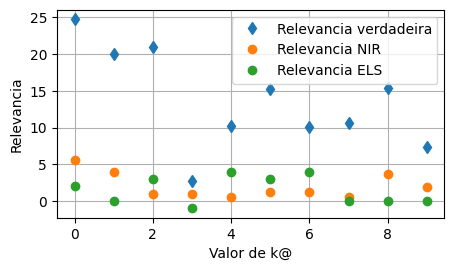

In [309]:
import matplotlib.pyplot as plt


# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(5, 2.7))
# ax.scatter(relevance, true_relevance, s=50, facecolor='C0', edgecolor='k')
ax.plot(metrics['true_dcg_k'], 'd', label='Relevancia verdadeira')
ax.plot(metrics['nir_dcg_k'], 'o', label='Relevancia NIR')
ax.plot([2, 0, 3, -1, 4, 3, 4, 0, 0, 0], 'o', label='Relevancia ELS')
ax.set_xlabel('Valor de k@')
ax.set_ylabel('Relevancia')
ax.legend()
ax.grid(True)
